# Klasyfikacja obiektów kosmicznych - Feature engineering - *walidacja*

*Wszelkie uwagi i dopiski zespołu walidacji dodane zostały do wyjściowego pliku kursywą.*

*Zespół walidacji wywołał cały kod dla danych developerskich (development_unit - dzielony na tym etapie na training_sample i validation_sample), żeby sprawdzić jego poprawność. Wywołanie przebiegło poprawnie. Walidacja będzie przeprowadzona na zbiorze danych walidacyjnych (validation_unit - wydzielonych przez grupę developerską na początku projektu) poprzez wywołanie na ww. zbiorze tych fragmentów kodu, które zespół developerski wywoływał na próbce validation_sample - w kodzie z dopiskiem 'test' w nazwach).* 

#### 0. Dane
#### 0.1. Pakiety

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#### 0.2. Podział danych na zbiór treningowy i testowy

*Nie dotyczy danych zespołu walidacji. Na tym etapie jedynie wczytujemy dane.*

In [5]:
# wczytanie danych
df = pd.read_csv('../data/validation_data.csv')

## 1. Istotne informacje z etapu I (EDA)
### 1.1. Cel biznesowy
Celem biznesowym zadania jest klasyfikacja typów obiektów kosmicznych (zbudowanie modelu, który będzie klasyfikował typy obiektów kosmicznych).

*Po prezentacjach pierwszego kamienia milowego zespół walidacyjny zrozumiał trochę lepiej pojęcie celu biznesowego - może fajnie by było dodać konkretne zastosowanie biznesowe takiego modelu, typu jakie firmy lub jacy klienci mogliby być potencjalnie zainteresowani kupnem takiego produktu?*

## 2. Znaczenie poszczególnych cech

### 2.2. Przydatne pojęcia kosmiczne
- 2.2.1. Celestial sphere: The celestial sphere is an imaginary sphere that has a large radius and is concentric on Earth. All objects in the sky can be conceived as being projected upon the inner surface of the celestial sphere, which may be centered on Earth or the observer.

- 2.2.2. Celestial equator: The celestial equator is the great circle of the imaginary celestial sphere on the same plane as the equator of Earth.

- 2.2.3. Ascension and declination: Ascension and declination both are used in astronomy and navigation in space. Ascension tells how far left or right the object is in the celestial sphere and declination tells how far up or down the object is in the celestial sphere.

- 2.2.4. Photometric system: The word photo means light and metry means measurement. So, measuring the brightness of the light which a human eye can perceive is called photometry. The UBV photometric system (from Ultraviolet, Blue, and Visual), also called the Johnson system, is a photometric system usually employed for classifying stars according to their colors. It was the first standardized photometric system.

- 2.2.5. Redshift: Redshift is a key concept for astronomers. The term can be understood literally — the wavelength of the light is stretched, so the light is seen as ‘shifted’ towards the red part of the spectrum. It reveals how an object in space (star/planet/galaxy) is moving compared to us. It lets astronomers measure the distance for the most distant (and therefore oldest) objects in our universe.

źródło: https://towardsdatascience.com/stellar-classification-a-machine-learning-approach-5e23eb5cadb1

*Duży plus za wprowadzenie pojęć, na pewno przydatne dla czytelnika nieznającego tematu.*
*Plus za wprowadzenie pojęć z astronomii, na pewno przydatne dla osoby nieznającej tematu. Wątpliwość - nawet z podaniem źródła, czy skopiowanie tekstu wprost, bez zaznaczenia że to cycta, na pewno jest ok?*

In [6]:
# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

X_test = df[imp_cols]
y_test = df['class'].values

### 2.4. Rozkład obiektów na sferze niebieskiej

Wykres ten można lepiej zrozumieć uwzględniając informację nr 2.2.3. z paragrafu 2.2. Przydatne pojęcia kosmiczne:

" 2.2.3. Ascension and declination: Ascension and declination both are used in astronomy and navigation in space. Ascension tells how far left or right the object is in the celestial sphere and declination tells how far up or down the object is in the celestial sphere."

*Plus za uwzględnienie uwag Prowadzącego z prezentacji (że można by dodać jakąś interpretację tego wykresu). Myślimy, że dobrze by było, gdybyście wyjaśnili to trochę bardziej własnymi słowami - tutaj ten sam fragment zacytowany jest drugi raz, a sparafrazowanie tego i przełożenie na polski - jak reszta fragmentów kodu - pomogłoby czytelnikowi nieznającego tematu astronomii.*

## 3. Normalizacja

In [8]:
# potrzebujemy wywołać metodę .fit_transform() na zbiorze danych treningowych, żeby móc zastosować to samo skalowanie dla danych walidacyjnych

# wczytanie danych
df = pd.read_csv('../data/development_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
X = scaling.fit_transform(X)

In [9]:
X_test = scaling.transform(X_test)

##  Inżynieria cech
## 4. Feature importance
### 4.1. Random Forest Classifier

Wnioski:
- Wykorzystując model Random Forest Classifier, stwierdzamy, że wśród istniejących cech, **redshift** jest tą najważniejszą.
- Pozostałe cechy są mało istotne w porównaniu z **redshift**.
- Wcześniej podejrzewaliśmy, że **spec_obj_ID** będzie istotna, tak nie jest.

*Wnioski wyciągnięte przez zespół developerski są poprawne.*


## 5. Nowe cechy

### 5.1. Wskaźniki kolor-kolor
Tworzenie indeksów kolor-kolor poprzez łączenie pomiarów strumienia z różnych filtrów. 

Wnioski:
- wszytskie cechy *kolor-kolor* okazały się być dużo istotniejsze niż pojedyncze wartości filtrów.

*Ogólnie cechy kolor-kolor są istotniejsze niż pojedyncze wartości, ale nie dla każdej kombinacji zmiennych przewaga rzeczywiście jest duża.*

### 5.2. Zmodyfikowane alfa i delta
Rozmieszczenie obiektów na sferze niebieksiej (patrz: 2.4.) sugeruje, że pewien stosunek zmiennych alfa i delta może mieć znaczenie przy identyfikacji obiektu kosmicznego.

Wnioski:
- Alfa i delta same w sobie mówią dużo więcej o klasie docelowej niż ich suma czy różnica.
- Iloczyn nic ważnego nie wprowadza do modelu.
- Inne dziłania matematyczne, mające sens, przeprowadzone na zmiennych alfa i delta wymagałyby zaawansowanej wiedzy astronomicznej, której nie posiadamy. 

*Ciekawa obserwacja, dobrze że ta zależność została sprawdzona, nawet jeśli nie pojawiły się nowe zmienne mające znaczenie dla modelu.*

### 5.3. Współczynniki wielkości

Uwagi:
- W nowych cechach pojawiły się wartości NaN, zastąpiono je medianą.
- Nie jest to inwazyjne działanie, bo na 49000 rekordów, dotyczy tylko jednego.

Wnioski:
- Maginute ratios pokazują dużo więcej niż podstawowe filtry.

*Literówka wyżej, ogólnie wnioski poprawne, zastąpienie nielicznych brakujących danych medianą też wydaje się być dobrym rozwiązaniem.
Pytanie: Dlaczego powstały NaNy?*

### 5.4. Kombinacja redshift z innymi cechami

Redshift i alpha

- Redshift*alpha moze wpływać pozytywnie na model.
- Pozostałe kolumny: redshift-alpha i redshift+alpha okazały się nieznaczące.

*Wnioski poprawne.*

Redshift i delta

- Redshift*delta moze wpływać pozytywnie na model.
- Pozostałe kolumny: redshift-delta i redshift+delta okazały się nieznaczące.

*Wnioski poprawne.*

Redshift i z, u, i, g, r

- Iloczyny redshift z filtrami mogą być przydatne w naszym modelowaniu.
- Pozostałe kombinacje nie są znaczące.

*Wnioski poprawne.*

### 5.4. Podsumowanie i wybranie cech do modelu

*Wnioski uzyskane przez obu developerów są spójne, kolumny wybrane do odrzucenia również. Zespół walidacji wyciągnąłby podobne wnioski na podstawie otrzymanych wykresów.*

## Modelowanie
### 1. Dokładaność algorytmów
Będziemy badać różne algorytmy. Definiujemy funkcję *score* obliczającą dokładność algorytmów.

In [10]:
def score(model, title = ""):
    model.fit(X, y)
    predicts = model.predict(X_test)

    # confusion matrix
    cm = confusion_matrix(y_test, predicts)
    print(f"{title} confusion matrix:")
    print(cm)


    fig = px.imshow(confusion_matrix(y_test, predicts),text_auto='.2f',
                    title = 'Heatmap of Confusion matrix')
    fig.show()

    accuracy = round(accuracy_score(y_test, predicts), 4)
    print(f"{title} accuracy: {accuracy}")

    return accuracy

### 1.1. Regresja logistyczna

In [11]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=101, solver='lbfgs', multi_class='multinomial',max_iter=10000)
lg_score = score(lg, "Logistic Regression") 

Logistic Regression confusion matrix:
[[17005   279   561]
 [  719  4958    23]
 [  594     2  5859]]


Logistic Regression accuracy: 0.9274


*Wartość uzyskana przez zespół deweloperski: 0.926, przez zespół walidujący: 0.927 - wyniki podobne.*

### 1.2. Random Forest

In [12]:
# random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, criterion='gini', bootstrap=True)
rf_score = score(rf, "Random Forest")

Random Forest confusion matrix:
[[17424   269   152]
 [  653  5046     1]
 [    1     0  6454]]


Random Forest accuracy: 0.9641


*Wartość uzyskana przez zespół deweloperski: 0.963, przez zespół walidujący: 0.964 - wyniki podobne.*

### 1.3. Naive Bayes 

In [13]:
# naive bayes gaussianNB
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB(priors=[0.5, 0.3, 0.2], var_smoothing=1e-6)   # prawdopodobieństwo klas (z takim ustawieniem accuracy jest wieksze niz z defaultowym)
nb_score = score(nb, "Naive Bayes GaussianNB")

Naive Bayes GaussianNB confusion matrix:
[[15498  2181   166]
 [  589  5110     1]
 [    1     4  6450]]


Naive Bayes GaussianNB accuracy: 0.9019


*Wartość uzyskana przez zespół deweloperski: 0.9016, przez zespół walidujący: 0.9019 - wyniki podobne.*

### 1.4. K Neighbors Classifier

In [14]:
# knn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_score = score(knn, "KNN")

KNN confusion matrix:
[[17267   180   398]
 [  512  5081   107]
 [  698    11  5746]]


KNN accuracy: 0.9365


*Wartość uzyskana przez zespół deweloperski: 0.9369, przez zespół walidujący: 0.9365 - wyniki podobne.*

### 1.5. Drzewa decyzyjne

In [15]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10)
dt_score = score(dt, "Decision Tree")

Decision Tree confusion matrix:
[[17532   238    75]
 [  479  5220     1]
 [   30     2  6423]]


Decision Tree accuracy: 0.9725


*Wartość uzyskana przez zespół deweloperski: 0.9726, przez zespół walidujący: 0.9722 - wyniki podobne.*

### 1.6. Drzewa decyzyjne: Gini

In [16]:
# gini
gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
gini_score = score(gini, "Gini")

Gini confusion matrix:
[[17479   252   114]
 [  746  4953     1]
 [    8     0  6447]]


Gini accuracy: 0.9626


*Wartość uzyskana przez zespół deweloperski: 0.9619, przez zespół walidujący: 0.9626 - wyniki podobne.*

### 1.7. Drzewa decyzyjne: entropia

In [17]:
# entropy
entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
entropy_score = score(entropy, "Entropy")

Entropy confusion matrix:
[[17481   249   115]
 [  743  4956     1]
 [    8     0  6447]]


Entropy accuracy: 0.9628


*Wartość uzyskana przez zespół deweloperski: 0.9621, przez zespół walidujący: 0.9628 - wyniki podobne.*

### 1.9. Podsumowanie

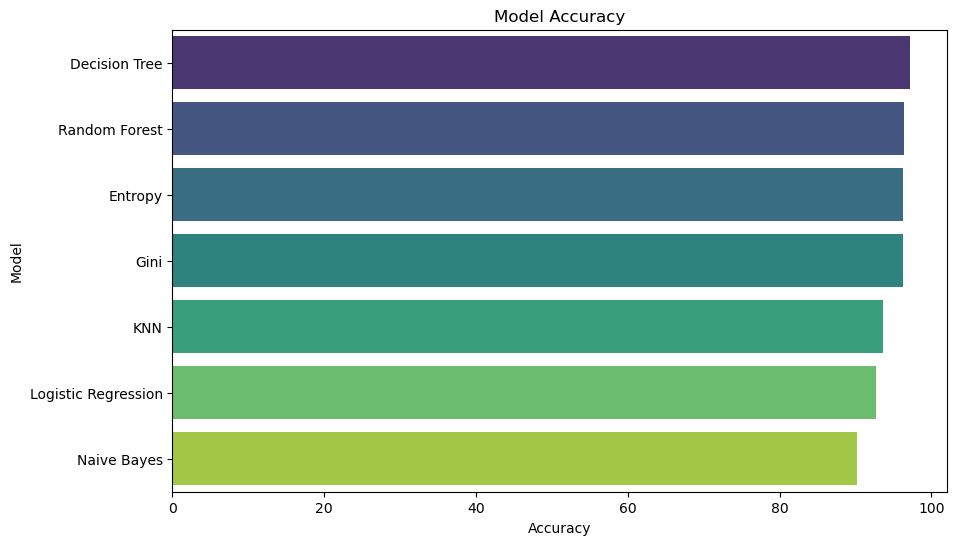

In [18]:
x = {'Score' : [lg_score, rf_score, nb_score, knn_score, dt_score, gini_score, entropy_score]}
df = pd.DataFrame(x)
df['Score'] = df['Score'] * 100
df['Model'] = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'Decision Tree', 'Gini', 'Entropy']
df = df.sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', data=df, palette='viridis')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


Powyższy wykres pokazuje dokładność modeli. Najdokłądniejszym jest Random Forest zaraz obok Decision Tree, Decision Tree: Entropy oraz Decision Tree: Gini.  

*Wyniki dla danych zespołu walidacyjnego nieznacznie się różnią, ale w ogólności bardzo zbliżone do tych otrzymanych przez zespół developerski.*